In [17]:
import numpy as np
import matplotlib.pyplot as plt #matplob lib
%matplotlib inline
import os

import astropy.io.ascii as at
from scipy.interpolate import griddata, LinearNDInterpolator, interp2d
import numpyro
import numpyro.distributions as dist
import jax
from jax import random
import jax.numpy as jnp

In [3]:
# read in our MIST isochrone
data = at.read("MIST_iso_67e56fd8ac521.iso.cmd")

# filter out AGB/RGB stars so we're left with just main sequence stars
ms = (data['EEP'] < 605) & (data['log_g'] > 2.0)
data = data[ms]

# sanity print mins and maxs of logg and teff
(min(data['log_g']), max(data['log_g']),
10**min(data['log_Teff']), 10**max(data['log_Teff']))

(np.float64(2.016473965578847),
 np.float64(5.219173330672141),
 np.float64(2852.90475694454),
 np.float64(6611.359927800581))

In [44]:
out = {}

out['iso'] = data['log_Teff', 'log_g', 'initial_mass']

# out['iso'] = 10**data['log_Teff'], data['log_g'], data['initial_mass']

out['iso']['Teff'] = 10**out['iso']['log_Teff']
del(out['iso']['log_Teff'])

out

{'iso': <Table length=325>
       log_g            initial_mass           Teff       
      float64             float64            float64      
 ------------------ ------------------- ------------------
  5.219173330672141 0.10331965605076723   2852.90475694454
  5.210097400095176 0.10722995675658707  2871.426772679346
  5.125557731436499 0.14551443880232373  3043.250270866061
  5.113599158725646 0.15196215136678998 3065.8589579837094
  5.101390956760364 0.15863977245194313  3088.979471101631
  5.089240988406002  0.1668724021671966  3110.692582312181
  5.073608290086558 0.17982274249296165 3135.6645730593646
  5.058022948354067 0.19279845940840507  3160.754584925618
  5.042676309900792 0.20552708463359626  3185.587810805356
                ...                 ...                ...
 2.2549880907637156  1.5620623761143935  4421.025583634862
  2.228578765081699  1.5623247724036857  4406.202257441944
  2.202190874455601   1.562577687538609  4391.516989111142
 2.1757419086978294    1.5628

In [3]:
# define and sample priors for teff and log(g)
# this is purely for this notebook and should not be implemented into uberMS
teff_prior = dist.Uniform(low=min(10**data['log_Teff']), high=max(10**data['log_Teff']))
sample_Teff_a = teff_prior.sample(random.PRNGKey(2))


logga_prior = dist.Uniform(low=min(data['log_g']), high=max(data['log_g']))
sample_logg_a = logga_prior.sample(random.PRNGKey(2))

q_prior = dist.Uniform(low=1E-6, high=1.0)
sample_q = q_prior.sample(random.PRNGKey(2))

(sample_Teff_a, sample_logg_a, sample_q)

(Array(5261.289, dtype=float32),
 Array(4.068735, dtype=float32),
 Array(0.6407914, dtype=float32))

In [23]:
## step 1:

# define and sample priors for teff and log(g)
# this is purely for this notebook and should not be implemented into uberMS
# teff_prior = dist.Uniform(low=min(10**data['log_Teff']), high=max(10**data['log_Teff']))
# sample_Teff_a = teff_prior.sample(random.PRNGKey(2))


# logga_prior = dist.Uniform(low=min(data['log_g']), high=max(data['log_g']))
# sample_logg_a = logga_prior.sample(random.PRNGKey(2))

# q_prior = dist.Uniform(low=1E-6, high=1.0)
# sample_q = q_prior.sample(random.PRNGKey(2))

# set samples manually
# sample_Teff_a = 4500
# sample_logg_a = 2.5
# sample_q = 0.65

# sample_Teff_a = 6500
# sample_logg_a = 3.8
# sample_q = 0.9

sample_Teff_a = 3000
sample_logg_a = 3.0
sample_q = 0.9

# print the sample we took
print('------ Samples ------')
print(sample_Teff_a, sample_logg_a, sample_q)

# define a tolerance to find the closest teff and logg
teff_tol = 100
logg_tol = 0.1
mb_tol = 0.05


# TODO: Test with these tolerances to start and 3000 K, 3.0, 0.9
# because it returns 1 value in the closest loggs, so let's so what happens
# there!!

# teff_tol = 1
# logg_tol = 0.00001
# mb_tol = 0.05


# define a condition to find the indices of the closest teff and logg
cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol

# check to make sure we have some points within the tolerances
# TODO: There is a better way to do this where it can dynamically
# choose whether to increase teff or logg tolerance independently,
# but this is good enough for now
add_teff_tol = 50
add_logg_tol = 0.05

while (jnp.size(jnp.nonzero(cond_logg & cond_teff)) == 0):
    print(f"no isochrone data within tolerance of {teff_tol} K, {logg_tol}")
    print(f"increasing teff_tol to {teff_tol + add_teff_tol} K")
    print(f"increasing logg_tol to {logg_tol + add_logg_tol}\n")
    teff_tol += add_teff_tol
    logg_tol += add_logg_tol
    
    cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
    cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol

    # if (jnp.size(jnp.nonzero(cond_teff)) == 0):
    #     print(f"Teff tolerance too small")
    #     print(f"increasing teff_tol to {teff_tol + add_teff_tol} K")

    #     teff_tol += add_teff_tol
    #     cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol

    # if (jnp.size(jnp.nonzero(cond_logg)) == 0):
    #     print(f"log(g) tolerance too small")
    #     print(f"increasing logg_tol to {logg_tol + add_logg_tol}")

    #     logg_tol += add_logg_tol
    #     cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol

------ Samples ------
3000 3.0 0.9
no isochrone data within tolerance of 100 K, 0.1
increasing teff_tol to 150 K
increasing logg_tol to 0.15000000000000002

no isochrone data within tolerance of 150 K, 0.15000000000000002
increasing teff_tol to 200 K
increasing logg_tol to 0.2

no isochrone data within tolerance of 200 K, 0.2
increasing teff_tol to 250 K
increasing logg_tol to 0.25

no isochrone data within tolerance of 250 K, 0.25
increasing teff_tol to 300 K
increasing logg_tol to 0.3

no isochrone data within tolerance of 300 K, 0.3
increasing teff_tol to 350 K
increasing logg_tol to 0.35

no isochrone data within tolerance of 350 K, 0.35
increasing teff_tol to 400 K
increasing logg_tol to 0.39999999999999997

no isochrone data within tolerance of 400 K, 0.39999999999999997
increasing teff_tol to 450 K
increasing logg_tol to 0.44999999999999996

no isochrone data within tolerance of 450 K, 0.44999999999999996
increasing teff_tol to 500 K
increasing logg_tol to 0.49999999999999994

n

In [ ]:
# jax.lax.while_loop might have to be used, but I cannot quite get it working
# atp... the size of the array of where both conditions are true is dynamic
# and I don't quite know how to make it static...
def condition(state):
    teff_tol, logg_tol = state

    cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
    cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol

    return (jnp.size(jnp.nonzero(cond_logg & cond_teff)) == 0)

def body(state):
    print(f"no isochrone data within tolerance of {teff_tol} K, {logg_tol}")
    print(f"increasing teff_tol to {teff_tol + add_teff_tol} K")
    print(f"increasing logg_tol to {logg_tol + add_logg_tol}\n")
    teff_tol, logg_tol = state
    
    teff_tol += add_teff_tol
    logg_tol += add_logg_tol
    
    cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
    cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol

    return cond_teff, cond_logg


cond_teff, cond_logg = jax.lax.while_loop(
    cond_fun=condition,
    body_fun=body,
    init_val=(teff_tol, logg_tol)
)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[]
The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX transformations.
The error occurred while tracing the function condition at C:\Users\Jared\AppData\Local\Temp\ipykernel_24168\3444390655.py:1 for while_cond. This concrete value was not available in Python because it depends on the values of the arguments state[0] and state[1].

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [ ]:
# cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
# cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol
jnp.size(jnp.nonzero(cond_logg & cond_teff))

1

In [9]:
print(jnp.size(jnp.nonzero(cond_teff)))
print(np.where(cond_teff == True))

print(jnp.size(jnp.nonzero(cond_logg)))
print(np.where(cond_logg == True))

print(jnp.size(jnp.nonzero(cond_teff & cond_logg)))
print(np.where(cond_teff & cond_logg == True))

79
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
       324]),)
190
(array([135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232

In [ ]:
## step 2:

closest_teff = jnp.where((cond_teff & cond_logg), 10**data['log_Teff'], 0)
closest_logg = jnp.where((cond_teff & cond_logg), data['log_g'], 0)

# print('------ Closest ------')
# print(f"closest logg:\n{closest_logg}")
# print(f"closest teff:\n{closest_teff}")

# print(np.where(closest_logg == True))
# print(np.where(closest_teff == True))

------ Closest ------
closest logg:
[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.     

In [ ]:
## step 3:

if ~(jnp.all(jnp.diff(idx_closest) == 1)):
    median_logg = jnp.median(closest_logg)
    # print(f"median closest logg: {median_logg}")
    idx_cts = jnp.where(data['log_g'][idx_closest] > median_logg)
    logg_cts = data['log_g'][idx_closest][idx_cts]
    teff_cts = 10**data['log_Teff'][idx_closest][idx_cts]


    # now do interpolation
    mass_a = jnp.interp(sample_Teff_a, teff_cts, data['initial_mass'][idx_closest][idx_cts])
    # print(f'closest masses: {data["initial_mass"][idx_closest][idx_cts]}')
    print(f"\n mass_a: {mass_a}")

    # find mass_b using mass_a and sample_q
    mass_b = mass_a * sample_q
    print(f"\n mass_b: {mass_b}")

    # get logg_b and teff_b
    # find closest mass to mass_b
    cond_mass_b = jnp.abs(data['initial_mass'] - mass_b) < mb_tol

    idx_closest_b = jnp.where(cond_mass_b)

    # the initial_mass column is sorted, so we do not need to check
    # for continuity of the indices
    logg_b = jnp.interp(mass_b, data['initial_mass'][idx_closest_b], data['log_g'][idx_closest_b])
    teff_b = jnp.interp(mass_b, data['initial_mass'][idx_closest_b], 10**data['log_Teff'][idx_closest_b])
    
    print("\n\n\n\n\n\n")
    print(logg_b, teff_b)
    print(data['log_g'][idx_closest_b], 10**data['log_Teff'][idx_closest_b])


    # closest_logg = data['log_g'][idx_closest]
    # closest_teff = 10**data['log_Teff'][idx_closest]




    # closest_mass_b = min(np.abs(data['initial_mass'] - mass_b))
    # print(closest_mass_b)
    # idx_closest_b = np.where(np.abs(data['initial_mass'] - mass_b) == closest_mass_b)
    # print(f"Teff_b: {10**data['log_Teff'][idx_closest_b]}")
    # print(f"logg_b: {data['log_g'][idx_closest_b]}")


    # plot
    fig, ax = plt.subplots()

    ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], label='isochrone', s=1)
    ax.scatter(logg_cts, teff_cts, s=5)

    # ax.set_xlim(3.7, sample_logg_a + 0.5)

    ax.scatter(sample_logg_a, sample_Teff_a, c=mass_a)

    ax.scatter(logg_b, teff_b, c=mass_b)

    ax.set_xlabel(r'$\log{(g)}$')
    ax.set_ylabel(r'$T_{eff}$')

    fig.colorbar(ax.collections[0], label=r'$M \, ({M_\odot})$')
    plt.show()

    
else:
    # 1d regular interpolation to get primary mass
    print(sample_Teff_a)
    print(jnp.shape(closest_teff))
    print(jnp.shape(data['initial_mass'][idx_closest]))
    mass_a = jnp.interp(sample_Teff_a, closest_teff, data['initial_mass'][idx_closest])
    print(f'closest masses: {data["initial_mass"][idx_closest]}')

    print(f"\n mass_a: {mass_a}")

    # find mass_b using mass_a and sample_q
    mass_b = mass_a * sample_q
    print(f"\n mass_b: {mass_b}")

    # get logg_b and teff_b
        # find closest mass to mass_b
    cond_mass_b = jnp.abs(data['initial_mass'] - mass_b) < mb_tol

    idx_closest_b = jnp.where(cond_mass_b)

    # the initial_mass column is sorted, so we do not need to check
    # for continuity of the indices
    logg_b = jnp.interp(mass_b, data['initial_mass'][idx_closest_b], data['log_g'][idx_closest_b])
    teff_b = jnp.interp(mass_b, data['initial_mass'][idx_closest_b], 10**data['log_Teff'][idx_closest_b])


    # plot
    fig, ax = plt.subplots()

    ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], label='isochrone', s=1)
    ax.scatter(closest_logg, closest_teff, s=5)

    ax.scatter(sample_logg_a, sample_Teff_a, c=mass_a)
    ax.scatter(logg_b, teff_b, c=mass_b)

    ax.set_xlabel(r'$\log{(g)}$')
    ax.set_ylabel(r'$T_{eff}$')

    fig.colorbar(ax.collections[0], label=r'$M \, ({M_\odot})$')
    plt.show()

    
    # print(logg_b, teff_b)
    # print(data['log_g'][idx_closest], 10**data['log_Teff'][idx_closest])




# interp = jnp.interp(sample_teff, 10**data['log_Teff'], data['initial_mass'])
# print(f"\n{data['log_g'][idx_closest]}\n{10**data['log_Teff'][idx_closest]}")

In [78]:
sample_Teff_a = 3000
sample_logg_a = 3.0
sample_q = 0.9

# print the sample we took
print(sample_Teff_a, sample_logg_a, sample_q)

# define a tolerance to find the closest teff and logg
teff_tol = 1500
logg_tol = 1.5
mb_tol = 0.5

# define a condition to find the indices of the closest teff and logg
cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol

# print(jnp.array(data['log_g']))

# print(data['log_g'])
    
closest_teff = jnp.where((cond_teff & cond_logg), 10**data['log_Teff'], jnp.nan)
closest_logg = jnp.where((cond_teff & cond_logg), data['log_g'], jnp.nan)
print(closest_teff, closest_logg)


# idx_closest = jnp.array(jnp.where(cond_teff & cond_logg))[0]

3000 3.0 0.9
[      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan    

In [ ]:
cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol

idx_closest = jnp.array(jnp.where(cond_teff & cond_logg))[0]
print(idx_closest, jnp.shape(idx_closest))

closest_logg = data['log_g'][idx_closest]
closest_teff = 10**data['log_Teff'][idx_closest]

if (jnp.all(jnp.diff(idx_closest) == 1)):
    print('it worked!')

[218 219 220 221 222 223 224 225 226] (9,)
it worked!


3000 3.0 0.9


here is the closest index[]


no stars within Teff tolerance of 100 K and 0.05
increasing teff_tol to 10000 K
no stars within log(g) tolerance of 0.05
increasing logg_tol to 5.0
closest logg:
      log_g       
------------------
3.0476735898513874
 3.022648871394688
2.9975684846995025
 2.972424517448437
closest teff:
     log_Teff     
------------------
 4818.213542445234
 4807.198202355315
4796.0627839105655
 4784.664753541063
3000
(4,)
(4,)
closest masses:    initial_mass   
------------------
 1.544232116695193
 1.545066579680086
1.5458845738027256
1.5466990801440368

 mass_a: 1.5442321300506592

 mass_b: 1.3898088932037354


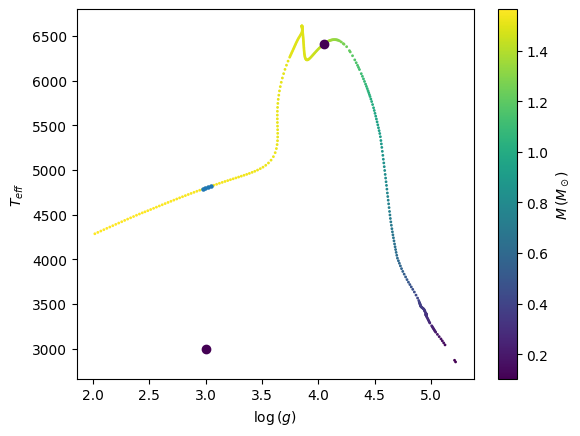

In [ ]:
# define and sample priors for teff and log(g)
# this is purely for this notebook and should not be implemented into uberMS
# teff_prior = dist.Uniform(low=min(10**data['log_Teff']), high=max(10**data['log_Teff']))
# sample_Teff_a = teff_prior.sample(random.PRNGKey(2))


# logga_prior = dist.Uniform(low=min(data['log_g']), high=max(data['log_g']))
# sample_logg_a = logga_prior.sample(random.PRNGKey(2))

# q_prior = dist.Uniform(low=1E-6, high=1.0)
# sample_q = q_prior.sample(random.PRNGKey(2))

# set samples manually
# sample_Teff_a = 4500
# sample_logg_a = 2.5
# sample_q = 0.65

# sample_Teff_a = 6500
# sample_logg_a = 3.8
# sample_q = 0.9

sample_Teff_a = 3000
sample_logg_a = 3.0
sample_q = 0.9

# print the sample we took
print(sample_Teff_a, sample_logg_a, sample_q)

# define a tolerance to find the closest teff and logg
teff_tol = 100
logg_tol = 0.05
mb_tol = 0.05


# define a condition to find the indices of the closest teff and logg
cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol

idx_closest = jnp.array(jnp.where(cond_teff & cond_logg))[0]
print(f"\n\nhere is the closest index{idx_closest}\n\n")

closest_logg = data['log_g'][idx_closest]
closest_teff = 10**data['log_Teff'][idx_closest]

# check to make sure we have some points within the tolerances
# if not, multiply the tolerances by 100 and try again
# this would better be done with a try/except block or while loop,
# but this is a quick fix
if (len(closest_teff) == 0):
    print(f"no stars within Teff tolerance of {teff_tol} K and {logg_tol}")
    print(f"increasing teff_tol to {teff_tol * 100} K")

    teff_tol = teff_tol * 100
    cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
    idx_closest = jnp.array(jnp.where(cond_teff & cond_logg))[0]
    closest_teff = 10**data['log_Teff'][idx_closest]
    
if (len(closest_logg) == 0):
    print(f"no stars within log(g) tolerance of {logg_tol}")
    print(f"increasing logg_tol to {logg_tol * 100}")

    logg_tol = logg_tol * 100
    cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol
    closest_logg = data['log_g'][idx_closest]



print(f"closest logg:\n{closest_logg}")
print(f"closest teff:\n{closest_teff}")

if ~(jnp.all(jnp.diff(idx_closest) == 1)):
    median_logg = jnp.median(closest_logg)
    # print(f"median closest logg: {median_logg}")
    idx_cts = jnp.where(data['log_g'][idx_closest] > median_logg)
    logg_cts = data['log_g'][idx_closest][idx_cts]
    teff_cts = 10**data['log_Teff'][idx_closest][idx_cts]


    # now do interpolation
    mass_a = jnp.interp(sample_Teff_a, teff_cts, data['initial_mass'][idx_closest][idx_cts])
    # print(f'closest masses: {data["initial_mass"][idx_closest][idx_cts]}')
    print(f"\n mass_a: {mass_a}")

    # find mass_b using mass_a and sample_q
    mass_b = mass_a * sample_q
    print(f"\n mass_b: {mass_b}")

    # get logg_b and teff_b
    # find closest mass to mass_b
    cond_mass_b = jnp.abs(data['initial_mass'] - mass_b) < mb_tol

    idx_closest_b = jnp.where(cond_mass_b)

    # the initial_mass column is sorted, so we do not need to check
    # for continuity of the indices
    logg_b = jnp.interp(mass_b, data['initial_mass'][idx_closest_b], data['log_g'][idx_closest_b])
    teff_b = jnp.interp(mass_b, data['initial_mass'][idx_closest_b], 10**data['log_Teff'][idx_closest_b])
    
    print("\n\n\n\n\n\n")
    print(logg_b, teff_b)
    print(data['log_g'][idx_closest_b], 10**data['log_Teff'][idx_closest_b])


    # closest_logg = data['log_g'][idx_closest]
    # closest_teff = 10**data['log_Teff'][idx_closest]




    # closest_mass_b = min(np.abs(data['initial_mass'] - mass_b))
    # print(closest_mass_b)
    # idx_closest_b = np.where(np.abs(data['initial_mass'] - mass_b) == closest_mass_b)
    # print(f"Teff_b: {10**data['log_Teff'][idx_closest_b]}")
    # print(f"logg_b: {data['log_g'][idx_closest_b]}")


    # plot
    fig, ax = plt.subplots()

    ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], label='isochrone', s=1)
    ax.scatter(logg_cts, teff_cts, s=5)

    # ax.set_xlim(3.7, sample_logg_a + 0.5)

    ax.scatter(sample_logg_a, sample_Teff_a, c=mass_a)

    ax.scatter(logg_b, teff_b, c=mass_b)

    ax.set_xlabel(r'$\log{(g)}$')
    ax.set_ylabel(r'$T_{eff}$')

    fig.colorbar(ax.collections[0], label=r'$M \, ({M_\odot})$')
    plt.show()

    
else:
    # 1d regular interpolation to get primary mass
    print(sample_Teff_a)
    print(jnp.shape(closest_teff))
    print(jnp.shape(data['initial_mass'][idx_closest]))
    mass_a = jnp.interp(sample_Teff_a, closest_teff, data['initial_mass'][idx_closest])
    print(f'closest masses: {data["initial_mass"][idx_closest]}')

    print(f"\n mass_a: {mass_a}")

    # find mass_b using mass_a and sample_q
    mass_b = mass_a * sample_q
    print(f"\n mass_b: {mass_b}")

    # get logg_b and teff_b
        # find closest mass to mass_b
    cond_mass_b = jnp.abs(data['initial_mass'] - mass_b) < mb_tol

    idx_closest_b = jnp.where(cond_mass_b)

    # the initial_mass column is sorted, so we do not need to check
    # for continuity of the indices
    logg_b = jnp.interp(mass_b, data['initial_mass'][idx_closest_b], data['log_g'][idx_closest_b])
    teff_b = jnp.interp(mass_b, data['initial_mass'][idx_closest_b], 10**data['log_Teff'][idx_closest_b])


    # plot
    fig, ax = plt.subplots()

    ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], label='isochrone', s=1)
    ax.scatter(closest_logg, closest_teff, s=5)

    ax.scatter(sample_logg_a, sample_Teff_a, c=mass_a)
    ax.scatter(logg_b, teff_b, c=mass_b)

    ax.set_xlabel(r'$\log{(g)}$')
    ax.set_ylabel(r'$T_{eff}$')

    fig.colorbar(ax.collections[0], label=r'$M \, ({M_\odot})$')
    plt.show()

    
    # print(logg_b, teff_b)
    # print(data['log_g'][idx_closest], 10**data['log_Teff'][idx_closest])




# interp = jnp.interp(sample_teff, 10**data['log_Teff'], data['initial_mass'])
# print(f"\n{data['log_g'][idx_closest]}\n{10**data['log_Teff'][idx_closest]}")

In [58]:
# idx_closest = jnp.array(jnp.where(cond_teff & cond_logg))[0]

cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol

closest_logg = data['log_g'][(jnp.abs(10**data['log_Teff'] - sample_Teff_a) < 1000) & (jnp.abs(data['log_g'] - sample_logg_a) < 2)]
closest_teff = 10**data['log_Teff'][(jnp.abs(10**data['log_Teff'] - sample_Teff_a) < 1000) & (jnp.abs(data['log_g'] - sample_logg_a) < 2)]
print(closest_logg, closest_teff)

      log_g       
------------------
  4.99056286544938
 4.985788251081776
  4.98103116096699
 4.976330797122005
4.9716186650492675
 4.966805313422794
4.9620583992202025
   4.9587794116507
 4.956451367835268
 4.954922378671603
               ...
 4.813238194888272
 4.800677192354123
 4.787966550469853
  4.77550353956476
 4.762840979459581
4.7503476419668145
4.7393079641006794
 4.729329659344572
 4.720286951331256
 4.711629126293988
Length = 53 rows      log_Teff     
------------------
 3288.303518519385
3299.9691639202615
 3312.506619690768
3324.8578124927417
3336.6323451892563
3348.4900848622906
 3359.945700851601
 3369.315377012065
3376.8223811647304
3381.7997908108005
               ...
 3718.444970405906
 3744.627944621346
3773.6399033555213
3803.6144802217045
3834.5000092109453
  3865.26564696944
3896.4463427514083
 3926.983665376593
3956.2163218444175
3984.4888121088175
Length = 53 rows


In [337]:
np.where((data['initial_mass'] == sorted(data['initial_mass'])) == False)

(array([], dtype=int64),)

In [314]:
if np.any(10**data['log_Teff'] == 6500):
    print("yes")
else:
    print("no")

no


In [ ]:
print('Closest logg:')
print(data['log_g'][idx_closest])

median_test = np.median(data['log_g'][idx_closest])
print(f'\nlogg median: {median_test}\n')

print(np.where(data['log_g'][idx_closest] > median_test))
print('Closest logg < median:')
print(data['log_g'][idx_closest][np.where(data['log_g'][idx_closest] < median_test)])

Closest logg:
      log_g       
------------------
 4.573512675692805
 4.568963101580793
 4.564374812131633
 4.560251123595951
4.5562167255013835
  3.63827600152586
 3.634837556165945
3.6284685443547584
3.6178449186100434

logg median: 4.5562167255013835

(array([5, 6, 7, 8]),)
Closest logg < median:
      log_g       
------------------
  3.63827600152586
 3.634837556165945
3.6284685443547584
3.6178449186100434


In [ ]:
# cond_logg = np.abs(data['log_g'] - sample_logg_a) < logg_tol

# pass the conditions to the isochrone
closest_teff = 10**data['log_Teff'][cond_teff & cond_logg]
closest_logg = data['log_g'][cond_teff & cond_logg]
print(closest_teff, closest_logg)


fig, ax = plt.subplots()
ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], s=1)
ax.scatter(closest_logg, closest_teff, c='r', s=25, label='Closest')
ax.scatter(sample_logg_a, sample_Teff_a, c='k', s=25, label='Sample')

ax.legend()
plt.show()
# closest_logg = data['log_g'][np.abs(data['log_g'] - sample_logg_a) < logg_tol]

# (closest_teff, closest_logg)


# np.abs(10**data['log_Teff'] - sample_Teff_a < teff_tol)

In [144]:
a = np.array([0,4,2,6,3])
np.where(a>2), a[np.where(a>2)]
a = np.delete(a, 3)
a
# smallest = np.pop(a[a>2]

array([0, 4, 2, 3])

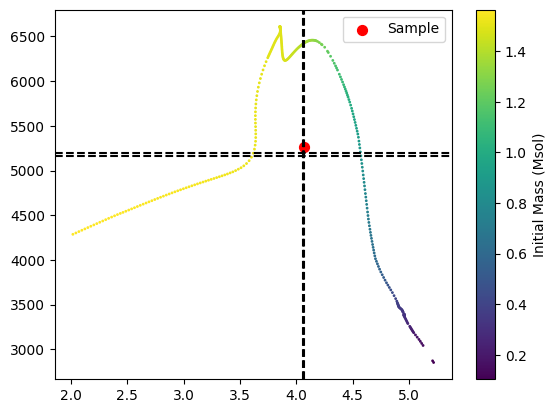

In [165]:
teff_tol = 100
logg_tol = 0.01

# np.abs(10**data['log_Teff'] - sample_Teff_a < teff_tol)

closest_teff = 10**data['log_Teff'][np.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol]
closest_logg = data['log_g'][np.abs(data['log_g'] - sample_logg_a) < logg_tol]

(closest_teff, closest_logg)


fig, ax = plt.subplots()
ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], s=1)
ax.scatter(sample_logg_a, sample_Teff_a, c='red', s=50, label='Sample')
ax.axhline(sorted(closest_teff)[0], c='black', ls='--')
ax.axhline(sorted(closest_teff)[1], c='black', ls='--')

ax.axvline(sorted(closest_logg)[0], c='black', ls='--')
ax.axvline(sorted(closest_logg)[1], c='black', ls='--')
#ax.scatter(min(closest_logg), min(closest_teff), c='blue', s=50, label='Closest')

ax.legend()
fig.colorbar(ax.collections[0], label='Initial Mass (Msol)')
# ax.set_xlim(4.0, 4.5)

# plt.plot(closest_logg, closest_teff[:len(closest_logg)])
# good = abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
# 10**data['log_Teff'][good]

In [74]:
# find closest two points in MIST isochrone to our sampled Teff and logg
teff_tol = 0.01
logg_tol = 0.01
closest_teff = min(abs(10**data['log_Teff'] - sample_Teff_a))
closest_logg = min(abs(data['log_g'] - sample_logg_a))
(closest_teff, closest_logg)


# 10**data['log_Teff'][abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol]

# data['log_Teff'][(abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol)]

(Array(8.731934, dtype=float32), Array(0.00210285, dtype=float32))

In [92]:
10**data['log_Teff']

2852.90475694454
2871.426772679346
3043.250270866061
3065.8589579837094
3088.979471101631
3110.692582312181
3135.6645730593646
3160.754584925618
3185.587810805356
3196.95550543449
3207.466642744423


In [90]:
np.partition(10**data['log_g'], 2) == sorted(10**data['log_g'])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [4]:
interp = LinearNDInterpolator(
    list(zip(data['log_Teff'], data['log_g'])), data['initial_mass']
)

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
C:\Users\Jared\AppData\Local\Temp\ipykernel_15664\3261272432.py:4: SyntaxWarning: invalid escape sequence '\o'
  plt.colorbar(ax.collections[0], label='Mass (M$_\odot$)')


array(nan)

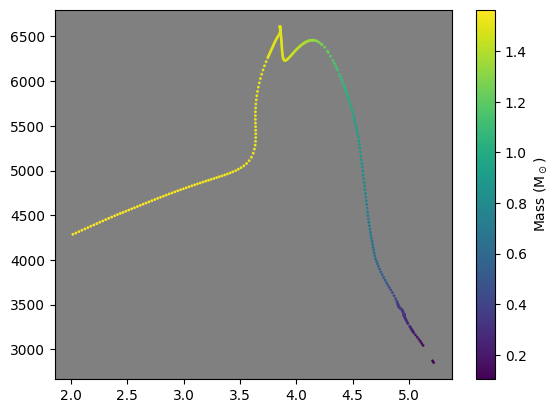

In [38]:
fig, ax = plt.subplots()
ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], s=1)
ax.set_facecolor('gray')
plt.colorbar(ax.collections[0], label='Mass (M$_\odot$)')
ax.scatter(2.1,5000,c=interp(2.1,5000))
interp(4.0, 6300)

In [ ]:
from scipy.interpolate import CloughTocher2DInterpolator

